In [1]:
import os
import sys
import dateutil.parser
import dateutil.relativedelta as dateutil_rd

spark_path = "C:/opt/spark"

os.environ['SPARK_HOME'] = spark_path
os.environ['HADOOP_HOME'] = spark_path

sys.path.append(spark_path + "/bin")
sys.path.append(spark_path + "/python")
sys.path.append(spark_path + "/python/pyspark/")
sys.path.append(spark_path + "/python/lib")
sys.path.append(spark_path + "/python/lib/pyspark.zip")
sys.path.append(spark_path + "/python/lib/py4j-0.9-src.zip")

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark import SQLContext

sc = SparkContext("local", "test")
sqlContext = SQLContext(sc)

In [2]:
print(sc)
print(sqlContext)

In [3]:
%pdb

Automatic pdb calling has been turned ON


In [4]:
%%javascript
/**********************************************************************************************
Known Mathjax Issue with Chrome - a rounding issue adds a border to the right of mathjax markup
https://github.com/mathjax/MathJax/issues/1300
A quick hack to fix this based on stackoverflow discussions: 
http://stackoverflow.com/questions/34277967/chrome-rendering-mathjax-equations-with-a-trailing-vertical-line
**********************************************************************************************/

$('.math>span').css("border-left-color","transparent")

<IPython.core.display.Javascript object>

In [5]:
%reload_ext autoreload
%autoreload 2

# DAMLAS - Machine Learning At Scale
## Assignment - HW3
Data Analytics and Machine Learning at Scale
Target, Minneapolis

---
__Name:__  Vicki J Seely   
__Class:__ DAMLAS Summer 2016     
__Email:__  vicki.seely@target.com     
__Week:__   03

# Table of Contents <a name="TOC"></a> 

1.  [HW Introduction](#1)   
2.  [HW References](#2)
3.  [HW Problems](#3)   
    3.0.  [Short Answer Questions](#HW3.0)    
    3.1.  [Word Count plus sorting](#HW3.1)   
    3.2.  [MLlib-centric Kmeans](#HW3.2)    
    3.3.  [Homegrown KMeans in Spark](#HW3.3)    
    3.4.  [Making Homegrown KMeans more efficient](#HW3.4)  
    3.5.  [OPTIONAL Weighted KMeans](#HW3.5)  
    3.6.  [OPTIONAL Linear Regression](#HW3.6)  
    3.7.  [OPTIONAL Error surfaces](#HW3.7)



<a name="1">
# 1 Instructions
[Back to Table of Contents](#TOC)
* Homework submissions are due by Tueday, 08/02/2016 at 11AM (CT).


* Prepare a single Jupyter note, please include questions, and question numbers in the questions and in the responses.
Submit your homework notebook via the following form:

   + [Submission Link - Google Form](http://goo.gl/forms/er3OFr5eCMWDngB72)


### Documents:
* IPython Notebook, published and viewable online.
* PDF export of IPython Notebook.
    
<a name="2">
# 2 Useful References
[Back to Table of Contents](#TOC)

* Karau, Holden, Konwinski, Andy, Wendell, Patrick, & Zaharia, Matei. (2015). Learning Spark: Lightning-fast big data analysis. Sebastopol, CA: O’Reilly Publishers.
* Hastie, Trevor, Tibshirani, Robert, & Friedman, Jerome. (2009). The elements of statistical learning: Data mining, inference, and prediction (2nd ed.). Stanford, CA: Springer Science+Business Media. __(Download for free [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/printings/ESLII_print10.pdf))__
* Ryza, Sandy, Laserson, Uri, Owen, Sean, & Wills, Josh. (2015). Advanced analytics with Spark: Patterns for learning from data at scale. Sebastopol, CA: O’Reilly Publishers.
---
* [Slides for Supervised-ML-Classification-via-GradientDescent](https://www.dropbox.com/s/uzoch1dwft8kaqw/Lecture-15-Supervised-ML-Classification-via-GradientDescent.pdf?dl=0)
* [Slides from High Entropy Friday]( https://www.dropbox.com/s/0dlvsff3660vvbk/Lecture-High-Entropy-Friday.pdf?dl=0)

---

<a name="HW3">
# 3 HW Problems
[Back to Table of Contents](#TOC)

<a name="3.0"></a><h2 style="color:darkblue"> HW3.0: Short answer questions </h2>
[Back to Table of Contents](#TOC)


__What is Apache Spark and how is it different to Apache Hadoop? __

Apache Spark was designed to make up for some of the shortcomings of Hadoop - namely Hadoop's inability to optimize for iterative algorithms and data analysis (i.e. loops on the same set of data). Spark is faster (it uses in memory processing/caching vs. Hadoop's disk storage) and more versitile (it can batch process AND process instream, perform machine learning and do iterative analysis on a single cluster).

__Fill in the blanks:
Spark API consists of interfaces to develop applications based on it in Java, Python, Scala and R. __

<hr>

__Using Spark, resource management can be done either in a single server instance or using a framework such as Mesos or Hadoop YARN in a distributed manner. __

<hr>

__What is an RDD and show a fun example of creating one and bringing the first element back to the driver program. __

An RDD is a 'Resilient Distributed Dataset' -- resilient (fault-tolerant so it can reproduce missing or faulty data partitions due to node failure), distributed (data is located on multiple nodes within a cluster) and dataset (a partioned collection of data such a key-value pairs or objects).

<hr>


In [6]:
%%writefile sample.txt
now is the
time 4 all
good men to
come to the
aid of their
country the quick
brown fox jumps
over the lazy
dog I pledge
allegience to the
flag of the
United States of
America and to
the republic for
which I stand
one nation under
God indivisible with
liberty and justice
for all Amen

Overwriting sample.txt


In [7]:
rdd = sc.textFile("sample.txt")
rdd.count()
rdd.first()

u'now is the'

<a name="HW3.1"> <h2 style="color:darkgreen">HW3.1 WordCount plus sorting </h2>
[Back to Table of Contents](#TOC)

The following notebooks will be useful to jumpstart this collection of Homework exercises:


* [Example Notebook with Debugging tactics in Spark](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/jqjllp8kmf1eolk/WordCountDebugging-Example.ipynb)
* [Word Count Quiz](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/vgmpivsi4rvqz0s/WordCountQuiz.ipynb)
* [Work Count Solution](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/dxv3dmp1vluuo8i/WordCountQuiz-Solution.ipynb)

---
In Spark write the code to count how often each word appears in a text document (or set of documents). Please use this homework document (with no solutions in it) as a the example document to run an experiment.  Report the following: 
* provide a sorted list of tokens in decreasing order of frequency of occurence limited to [top 20 most frequent only] and [bottom 10 least frequent]. 


__OPTIONAL__ 
Feel free to do a secondary sort where words with the same frequncy are sorted alphanumerically increasing. Plseas refer to the [following notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/uu5afr3ufpm9fy8/SecondarySort.ipynb)
 for examples of secondary sorts in Spark. Please provide the following [top 20 most frequent terms only] and [bottom 10 least frequent terms]

__NOTE__ [Please incorporate all referenced notebooks directly into this master notebook as cells for HW submission. I.e., HW submissions should comprise of just one notebook]__

In [8]:
logFileNAME = 'sample.txt'
text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(0, 1)  \
    .map(lambda x: (x[1], x[0])) 
    
wordCounts = counts.collect()

wordCounts

[(u'the', 7),
 (u'to', 4),
 (u'of', 3),
 (u'and', 2),
 (u'all', 2),
 (u'for', 2),
 (u'I', 2),
 (u'United', 1),
 (u'pledge', 1),
 (u'God', 1),
 (u'over', 1),
 (u'one', 1),
 (u'justice', 1),
 (u'come', 1),
 (u'fox', 1),
 (u'liberty', 1),
 (u'their', 1),
 (u'republic', 1),
 (u'4', 1),
 (u'which', 1),
 (u'under', 1),
 (u'America', 1),
 (u'is', 1),
 (u'brown', 1),
 (u'lazy', 1),
 (u'good', 1),
 (u'jumps', 1),
 (u'men', 1),
 (u'nation', 1),
 (u'flag', 1),
 (u'aid', 1),
 (u'now', 1),
 (u'with', 1),
 (u'indivisible', 1),
 (u'Amen', 1),
 (u'dog', 1),
 (u'States', 1),
 (u'stand', 1),
 (u'time', 1),
 (u'quick', 1),
 (u'allegience', 1),
 (u'country', 1)]

In [9]:
print 'Top 5'
wordCounts[:5]

Top 5


[(u'the', 7), (u'to', 4), (u'of', 3), (u'and', 2), (u'all', 2)]

In [10]:
print 'Bottom 5'
wordCounts[-5:]

Bottom 5


[(u'stand', 1),
 (u'time', 1),
 (u'quick', 1),
 (u'allegience', 1),
 (u'country', 1)]

<a name="HW3.1.1"><h2 style="color:darkgreen">HW3.1.1 </h2>
[Back to Table of Contents](#TOC)

Modify the above word count code to count words that begin with lower case letters (a-z) and report your findings. Again sort the output words in decreasing order of frequency.


In [11]:
import re

text_file = sc.textFile(logFileNAME)
counts = text_file.flatMap(lambda line: line.split(" ")) \
    .filter(lambda word: re.findall('^[a-z]+',word)) \
    .map(lambda word: (word, 1)) \
    .reduceByKey(lambda a, b: a + b, 1) \
    .map(lambda x: (x[1], x[0])) \
    .sortByKey(0, 1)  \
    .map(lambda x: (x[1], x[0])) 
    
wordCounts = counts.collect()

wordCounts

[(u'the', 7),
 (u'to', 4),
 (u'of', 3),
 (u'and', 2),
 (u'all', 2),
 (u'for', 2),
 (u'pledge', 1),
 (u'over', 1),
 (u'one', 1),
 (u'justice', 1),
 (u'come', 1),
 (u'fox', 1),
 (u'liberty', 1),
 (u'their', 1),
 (u'republic', 1),
 (u'which', 1),
 (u'under', 1),
 (u'is', 1),
 (u'brown', 1),
 (u'lazy', 1),
 (u'good', 1),
 (u'jumps', 1),
 (u'men', 1),
 (u'nation', 1),
 (u'flag', 1),
 (u'allegience', 1),
 (u'now', 1),
 (u'with', 1),
 (u'indivisible', 1),
 (u'dog', 1),
 (u'stand', 1),
 (u'time', 1),
 (u'quick', 1),
 (u'aid', 1),
 (u'country', 1)]

In [12]:
print 'Top 5'
wordCounts[:5]

Top 5


[(u'the', 7), (u'to', 4), (u'of', 3), (u'and', 2), (u'all', 2)]

In [13]:
print 'Bottom 5'
wordCounts[-5:]

Bottom 5


[(u'stand', 1), (u'time', 1), (u'quick', 1), (u'aid', 1), (u'country', 1)]

<a name="HW3.2"> <h2 style="color:darkblue"> HW3.2: MLlib-centric KMeans</h2>
[Back to Table of Contents](#TOC)

Using the following  MLlib-centric KMeans code snippet: 

<pre>
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt


# Load and parse the data
# NOTE  kmeans_data.txt is available here 
#          https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 
data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10,
        runs=10, initializationMode="random")

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

# Save and load model
clusters.save(sc, "myModelPath")
sameModel = KMeansModel.load(sc, "myModelPath")

</pre>

__NOTE__ <p> The  __kmeans_data.txt__ is available here https://www.dropbox.com/s/q85t0ytb9apggnh/kmeans_data.txt?dl=0 

__TASKS__
* Run this code snippet and list the clusters that your find.
* compute the Within Set Sum of Squared Errors for the found clusters. Comment on your findings.

In [14]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

data = sc.textFile("kmeans_data.txt")  
parsedData = data.map(lambda line: array([float(x) for x in line.split(' ')]))

# Build the model (cluster the data)
clusters = KMeans.train(parsedData, 2, maxIterations=10, initializationMode="random")

clusters.clusterCenters

[array([ 0.1,  0.1,  0.1]), array([ 9.1,  9.1,  9.1])]

In [15]:
def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

WSSSE = parsedData.map(lambda point: error(point)).reduce(lambda x, y: x + y)
print("Within Set Sum of Squared Error = " + str(WSSSE))

Within Set Sum of Squared Error = 0.692820323028


In [ ]:
# Save and load model
clusters.save(sc,"HW3_KMeans")
sameModel = KMeansModel.load(sc, "HW3_KMeans")

<a name="HW3.3"><h2 style="color:darkgreen"> HW3.3: Homegrown KMeans in Spark </h2>
[Back to Table of Contents](#TOC)

Download the following KMeans [notebook](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb).

Generate 3 clusters with 100 (one hundred) data points per cluster (using the code provided). Plot the data.
Then run MLlib's Kmean implementation on this data  and report your results as follows:

* plot the resulting clusters after 1 iteration, 10 iterations, after 20 iterations, after 100 iterations.
* in each plot please report the Within Set Sum of Squared Errors for the found clusters (as part of the title WSSSE). Comment on the progress of this measure as  the KMEans algorithms runs for more iterations. Then plot the WSSSE as a function of the iteration (1, 10, 20, 30, 40, 50, 100).



In [16]:
 %matplotlib inline
import numpy as np
import pylab 
import json
size1 = size2 = size3 = 1000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('data.txt',data,delimiter = ',')

In [17]:
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

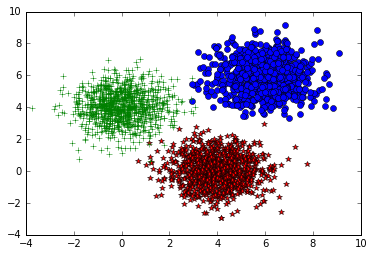

In [18]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

Iterations: 1, WSSSE: 7509.49633698
[array([ 6.63233557,  4.38904275]), array([ 0.8913606 ,  2.75909431]), array([ 4.92866713,  3.66295688])]


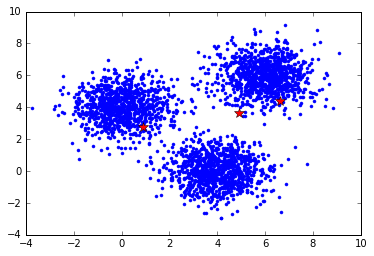

In [19]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt

def error(point):
    center = clusters.centers[clusters.predict(point)]
    return sqrt(sum([x**2 for x in (point - center)]))

k = 3

data = sc.textFile("data.txt")  
parsedData2 = data.map(lambda line: array([float(x) for x in line.split(',')]))

clusters = KMeans.train(parsedData2, k, maxIterations=1, seed=626, initializationMode="random")
iter_clusters = clusters.clusterCenters
WSSSE = parsedData2.map(lambda point: error(point)).reduce(lambda x, y: x + y)

print "Iterations: 1, WSSSE: " + str(WSSSE)
print iter_clusters
plot_iteration(iter_clusters)


Iterations: 10, WSSSE: 3706.72734243
[array([ 5.97529278,  5.98603963]), array([-0.01039916,  4.04958454]), array([ 3.95951625,  0.02296267])]


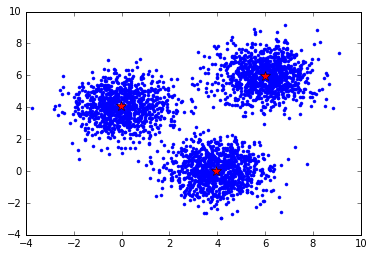

In [20]:
clusters = KMeans.train(parsedData2, k, maxIterations=10, seed=626, initializationMode='random')
iter_clusters = clusters.clusterCenters
WSSSE = parsedData2.map(lambda point: error(point)).reduce(lambda x, y: x + y)

print "Iterations: 10, WSSSE: " + str(WSSSE)
print iter_clusters
plot_iteration(iter_clusters)

Iterations: 20, WSSSE: 3706.72734243
[array([ 5.97529278,  5.98603963]), array([-0.01039916,  4.04958454]), array([ 3.95951625,  0.02296267])]


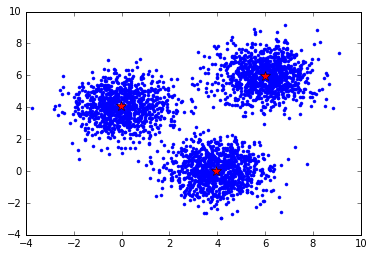

In [21]:
clusters = KMeans.train(parsedData2, k, maxIterations=20, seed=626, initializationMode='random')
iter_clusters = clusters.clusterCenters
WSSSE = parsedData2.map(lambda point: error(point)).reduce(lambda x, y: x + y)

print "Iterations: 20, WSSSE: " + str(WSSSE)
print iter_clusters
plot_iteration(iter_clusters)

Iterations: 100, WSSSE: 3706.72734243
[array([ 5.97529278,  5.98603963]), array([-0.01039916,  4.04958454]), array([ 3.95951625,  0.02296267])]


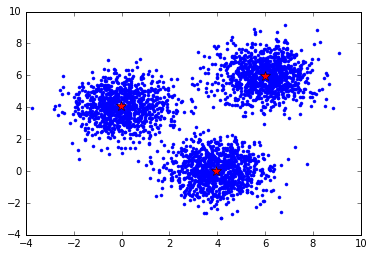

In [22]:
clusters = KMeans.train(parsedData2, k, maxIterations=100, seed=626, initializationMode='random')
iter_clusters = clusters.clusterCenters
WSSSE = parsedData2.map(lambda point: error(point)).reduce(lambda x, y: x + y)

print "Iterations: 100, WSSSE: " + str(WSSSE)
print iter_clusters
plot_iteration(iter_clusters)

<a name="HW3.4"><h2 style="color:darkblue"> HW3.4: KMeans Experiments  </h2>
[Back to Table of Contents](#TOC)

Using this provided [homegrown Kmeans code](http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/3nsthvp8g2rrrdh/EM-Kmeans.ipynb)   repeat the experiments in HW3.3. Explain any differences between the results in HW3.3 and HW3.4. 

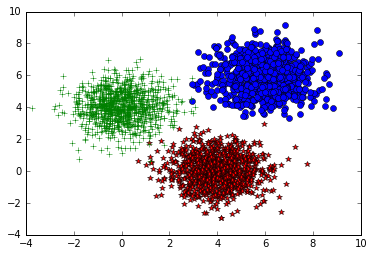

In [23]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

In [27]:
import numpy as np

#Calculate which class each data point belongs to
def nearest_centroid(line):
    x = np.array([float(f) for f in line.split(',')])
    closest_centroid_idx = np.sum((x - centroids)**2, axis=1).argmin()
    return (closest_centroid_idx,(x,1))

#plot centroids and data points for each iteration
def plot_iteration(means):
    pylab.plot(samples1[:, 0], samples1[:, 1], '.', color = 'blue')
    pylab.plot(samples2[:, 0], samples2[:, 1], '.', color = 'blue')
    pylab.plot(samples3[:, 0], samples3[:, 1],'.', color = 'blue')
    pylab.plot(means[0][0], means[0][1],'*',markersize =10,color = 'red')
    pylab.plot(means[1][0], means[1][1],'*',markersize =10,color = 'red')
    pylab.plot(means[2][0], means[2][1],'*',markersize =10,color = 'red')
    pylab.show()

Iteration1: WSSSE => 
[[ 1.12284615  0.29437612]
 [ 3.95300766  2.65929304]
 [ 2.0180828   5.68439438]]


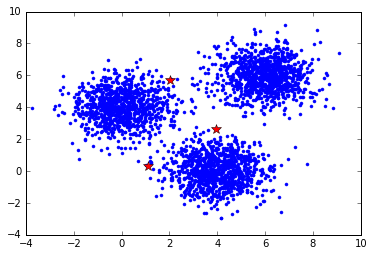

Iteration10: WSSSE => 
[[ 2.16287018  0.49740493]
 [ 5.37847628  2.9257081 ]
 [ 2.02100804  5.26660265]]


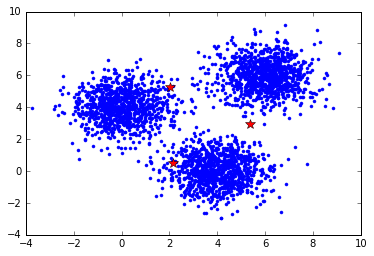

Iteration20: WSSSE => 
[[ 3.2612558   0.12544225]
 [ 6.05272768  4.83415889]
 [ 0.86884945  4.71972058]]


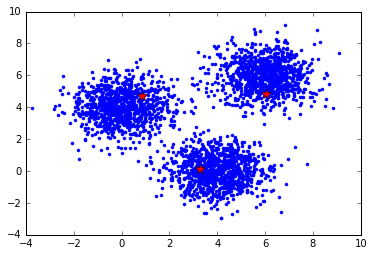

Iteration100: WSSSE => 
[[ 3.93288729  0.03160561]
 [ 6.002122    5.98203928]
 [ 0.01368868  4.08442623]]


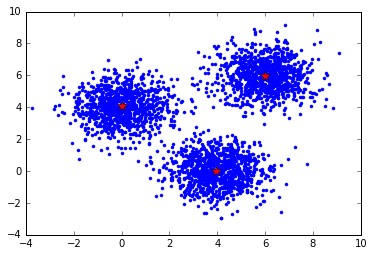

Final Results: Iteration100
[[ 3.93288729  0.03160561]
 [ 6.002122    5.98203928]
 [ 0.01368868  4.08442623]]


In [32]:
K = 3
# Initialization: initialization of parameter is fixed to show an example
centroids = np.array([[0.0,0.0],[2.0,2.0],[0.0,7.0]])

D = sc.textFile("./data.txt").cache()
iter_num = 0
for i in range(100):  
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on cluster ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    iter_num = iter_num + 1 
    if i == 0 or i == 9 or i == 19 or i == 99:
        print "Iteration" + str(iter_num) + ': WSSSE => ' #+ str(WSSSE)
        centroids = centroids_new
        print centroids
        plot_iteration(centroids)
print "Final Results: Iteration" + str(iter_num)
print centroids

<a name="HW3.4.1"><h2 style="color:darkblue"> HW3.4.1: Making Homegrown KMeans more efficient  </h2>
[Back to Table of Contents](#TOC)

The above provided homegrown KMeans implentation in not the most efficient. How can you make it more efficient? Make this change in the code and show it work and comment on the gains you achieve. 

### HINT: have a look at  [this linear regression notebook](    http://nbviewer.jupyter.org/urls/dl.dropbox.com/s/atzqkc0p1eajuz6/LinearRegression-Notebook-Challenge.ipynb)

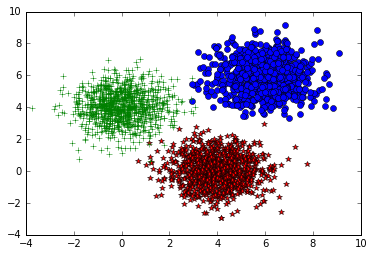

In [33]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.show()

Initialization:
[array([ 6.63233557,  4.38904275]), array([ 0.8913606 ,  2.75909431]), array([ 4.92866713,  3.66295688])]
Iteration1
[[ 6.24911701  6.08399868]
 [ 0.81366952  2.87073141]
 [ 4.54035967  1.26096021]]


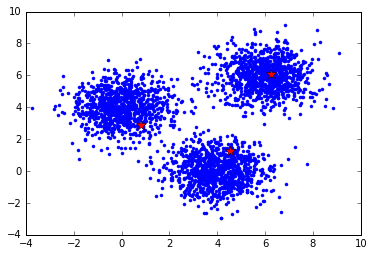

Iteration10
[[ 5.98054136  6.00088526]
 [ 0.02346829  3.97615591]
 [ 4.02017212  0.03063973]]


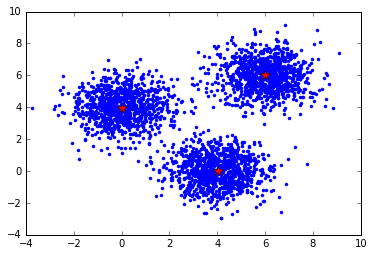

Iteration20
[[ 5.97529278  5.98603963]
 [-0.01039916  4.04958454]
 [ 3.95951625  0.02296267]]


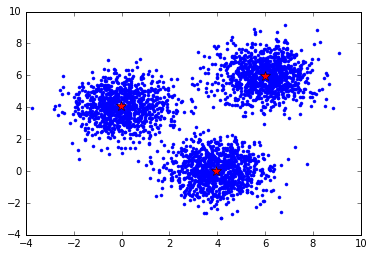

Final Results - Iteration20:
[[ 5.97529278  5.98603963]
 [-0.01039916  4.04958454]
 [ 3.95951625  0.02296267]]


In [41]:
clusters = KMeans.train(parsedData2, k, maxIterations=1, seed=626, initializationMode='random')
centroids = clusters.clusterCenters
print "Initialization:"
print centroids

D = sc.textFile("./data.txt").cache()
iter_num = 0
for i in range(100):
    res = D.map(nearest_centroid).reduceByKey(lambda x,y : (x[0]+y[0],x[1]+y[1])).collect()
    res = sorted(res,key = lambda x : x[0])  #sort based on clusted ID
    centroids_new = np.array([x[1][0]/x[1][1] for x in res])  #divide by cluster size
    if np.sum(np.absolute(centroids_new-centroids))<0.01:
        break
    iter_num = iter_num + 1 
    if i == 0 or i == 9 or i == 19 or i == 99:
        print "Iteration" + str(iter_num)
        centroids = centroids_new
        print centroids
        plot_iteration(centroids)
print "Final Results - Iteration" +str(iter_num) + ":"
print centroids

[Back to Table of Contents](#TOC)
<center><div class='jumbotron'><h2 style='color:green'>-------  END OF HWK 9 --------</h2></div></center>